In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline
from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.43:48741 Dashboard: http://10.148.0.43:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


_____________
# 2. read w'b' (spatially averaged)

In [5]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'
wb_prime_filter = xr.open_zarr(out_dir_zarr+'wb_prime_1day_filter.zarr')
wb_prime_filter

<xarray.Dataset>
Dimensions:          (depth: 52, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time             (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
Data variables:
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>

In [7]:
# Coarse-grained PI (spatial average and cumulative integral)
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter_5d_all.zarr')
PI_cg_smean = PI_cg.PI_cg_smean
PI_cg_smean

<xarray.DataArray 'PI_cg_smean' (depth: 52, time: 9415)>
dask.array<zarr, shape=(52, 9415), dtype=float32, chunksize=(1, 9415), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

In [8]:
ds = xr.merge([PI_cg_smean,wb_prime_filter])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
#ds.persist()
ds

<xarray.Dataset>
Dimensions:          (depth: 52, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg_smean      (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>

In [10]:
winter = ds.isel(depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00'))
winter

<xarray.Dataset>
Dimensions:          (depth: 23, time: 2185)
Coordinates:
  * depth            (depth) float64 52.69 60.28 68.69 ... 410.4 441.3 473.3
  * time             (time) datetime64[ns] 2011-12-01 ... 2012-03-01
Data variables:
    PI_cg_smean      (depth, time) float32 dask.array<chunksize=(1, 2185), meta=np.ndarray>
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(2185, 1), meta=np.ndarray>

In [13]:
# save
file_out = out_dir_zarr+'/wb_PI_winter_1016.nc'
%time winter.to_netcdf(file_out, mode='w')   

CPU times: user 252 ms, sys: 36 ms, total: 288 ms
Wall time: 2.8 s


_____________
# 3. read w'b' (4D)

In [6]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'

D = [xr.open_zarr(out_dir_store+'wb_prime_d%02d.zarr'%(depth)) for depth in range(52)]
wb_prime = xr.concat(D, dim='depth')
wb_prime

tornado.application - ERROR - Uncaught exception GET /workers/ws (10.148.1.145)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/workers/ws', version='HTTP/1.1', remote_ip='10.148.1.145')
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 135, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


<xarray.Dataset>
Dimensions:          (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
    XC               (lat, lon) float32 -18.03125 -18.010416 ... -14.364583
    CS               (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Depth            (lat, lon) float32 4658.816 4647.708 ... 4070.18 4057.071
    YC               (lat, lon) float32 47.404716 47.404716 ... 49.98778
    rA               (lat, lon) float32 2302204.5 2302204.5 ... 2089898.9
    SN               (lat, lon) float32 -2.519282e-13 -0.0 ... -2.651958e-13
  * lat              (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon              (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time             (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
Data variables:
    wb_prime_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>

In [9]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg_butter = xr.open_zarr(out_dir_store+'PI_cg_butter_5d.zarr')
PI_cg_butter

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    PI_cg    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>

In [10]:
# Coarse-grained PI (spatial average and cumulative integral)

ds = xr.merge([PI_cg_butter,wb_prime])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
#ds.persist()
ds

<xarray.Dataset>
Dimensions:          (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat              (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon              (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC               (lat, lon) float32 -18.03125 -18.010416 ... -14.364583
    CS               (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Depth            (lat, lon) float32 4658.816 4647.708 ... 4070.18 4057.071
    YC               (lat, lon) float32 47.404716 47.404716 ... 49.98778
    rA               (lat, lon) float32 2302204.5 2302204.5 ... 2089898.9
    SN               (lat, lon) float32 -2.519282e-13 -0.0 ... -2.651958e-13
Data variables:
    PI_cg            (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
  

In [11]:
winter = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00'))
winter

<xarray.Dataset>
Dimensions:          (depth: 23, lat: 197, lon: 173, time: 2185)
Coordinates:
  * depth            (depth) float64 52.69 60.28 68.69 ... 410.4 441.3 473.3
  * lat              (lat) float64 47.43 47.44 47.46 47.47 ... 49.94 49.95 49.96
  * lon              (lon) float64 -17.99 -17.97 -17.95 ... -14.45 -14.43 -14.41
  * time             (time) datetime64[ns] 2011-12-01 ... 2012-03-01
    XC               (lat, lon) float32 -17.989584 -17.96875 ... -14.40625
    CS               (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Depth            (lat, lon) float32 4616.97 4583.0806 ... 4112.6475 4098.188
    YC               (lat, lon) float32 47.43113 47.43113 ... 49.962532
    rA               (lat, lon) float32 2300021.2 2300021.2 ... 2091959.9
    SN               (lat, lon) float32 2.520546e-13 ... 5.3011333e-13
Data variables:
    PI_cg            (depth, time, lat, lon) float32 dask.array<chunksize=(1, 2185, 1, 173), meta=np.ndarray>
    wb_prime_singl

In [13]:
winter.load()

<xarray.Dataset>
Dimensions:          (depth: 23, lat: 197, lon: 173, time: 2185)
Coordinates:
  * depth            (depth) float64 52.69 60.28 68.69 ... 410.4 441.3 473.3
  * lat              (lat) float64 47.43 47.44 47.46 47.47 ... 49.94 49.95 49.96
  * lon              (lon) float64 -17.99 -17.97 -17.95 ... -14.45 -14.43 -14.41
  * time             (time) datetime64[ns] 2011-12-01 ... 2012-03-01
    XC               (lat, lon) float32 -17.989584 -17.96875 ... -14.40625
    CS               (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Depth            (lat, lon) float32 4616.97 4583.0806 ... 4112.6475 4098.188
    YC               (lat, lon) float32 47.43113 47.43113 ... 49.962532
    rA               (lat, lon) float32 2300021.2 2300021.2 ... 2091959.9
    SN               (lat, lon) float32 2.520546e-13 ... 5.3011333e-13
Data variables:
    PI_cg            (depth, time, lat, lon) float32 1.8125115e-09 ... -2.299601e-09
    wb_prime_single  (depth, time, lat, lon

KeyboardInterrupt: 

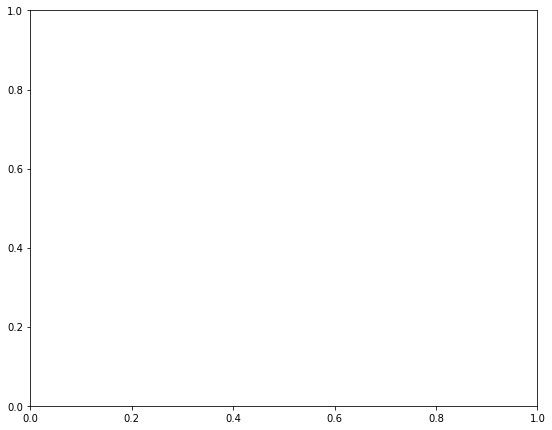

In [12]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)

winter.plot.scatter(y='PI_cg', x='wb_prime_single')

#plt.yscale('logit')
#plt.xscale('logit')

#ax.set_xlim([-10e-25,10e-19])
#plt.axis([10e-26,10e-19, 10e-12,10e-6])


In [14]:
from xhistogram.xarray import histogram

In [ ]:
y_bins = np.arange(-1e-8, 0, 1e-9)
x_bins = np.arange(0, 5e-8, 1e-9)
hTS = histogram(winter.PI_cg, winter.wb_prime_single, bins=[y_bins, x_bins])
hTS#.persist()

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


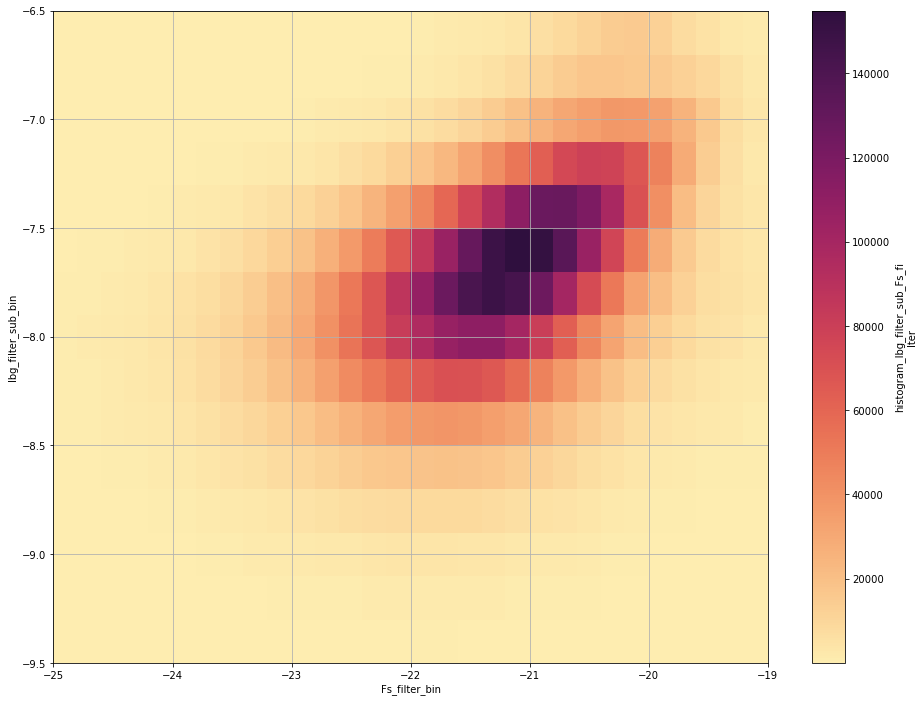

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


In [21]:
fig = plt.figure(figsize=(16,12))

ax = plt.subplot(111)
hTS.plot(cmap=cm.matter)
ax.grid()

In [14]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
